In [9]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from shapely.geometry import mapping

In [3]:
forest = gpd.read_file("D:/Forest-monitoring-ML/Data/forest data/forestBW.shp")

forest.head()

,distrikt,abteilung,revier,bestand,ba1,ba_p_1,ba2,ba_p_2,ba3,ba_p_3,ba4,ba_p_4,ba5,ba6,ba_p_5,ba_p_6,Shape_Leng,Shape_Area,geometry
0,1,11,1,r9,Fi,95,Bu,5,Dgl,0,Kie,0,None,None,0,0,98.713907,556.28005,"POLYGON Z ((443148.43 5393341.2 0, 443113.31 5..."
1,22,5,4,d6,Dgl,90,Fi,10,Bi,0,Bu,0,Kir,REi,0,0,696.782687,13716.69430,"POLYGON Z ((442620.26 5395409.82 0, 442646.15 ..."
2,22,5,4,d6,Dgl,90,Fi,10,Bi,0,Bu,0,Kir,REi,0,0,458.887875,7751.67540,"POLYGON Z ((442464.5 5395243.63 0, 442470.39 5..."
3,22,4,4,d5,Dgl,95,Bu,5,Ei,0,Fi,0,Kir,None,0,0,644.148733,10323.03440,"POLYGON Z ((442246.58 5395541.55 0, 442250.01 ..."
4,22,4,4,d5,Dgl,95,Bu,5,Ei,0,Fi,0,Kir,None,0,0,317.097448,5055.68960,"POLYGON Z ((442458.82 5395479.4 0, 442421.52 5..."


In [7]:
species_mapping = {
    'Fi': 1,    # Fichte (Spruce)
    'Dgl': 2,   # Douglasie (Douglas Fir)
    'Bu': 3,    # Buche (Beech)
    'REi': 4,   # Roteiche (Red Oak)
    'Kie': 5,   # Kiefer (Pine)
    'Lbh': 6,   # Lärche-Buche hybrid?
    'BAh': 7,   # Bergahorn (Sycamore)
    'REr': 8,   # Roterle (Red Alder)
    'Wei': 9,   # Weide (Willow)
    'HPa': 10,  # Hainbuche (Hornbeam)
    'Ei': 11,   # Eiche (Oak)
    'Rob': 12,  # Robinie (Black Locust)
    'Ndh': 13,  # Nadelholz (Coniferous Wood)
    'sNb': 14   # sonst. Nadelbaum (Other conifer)
}

gdf['species_id'] = gdf['ba1'].map(species_mapping)

In [11]:
# Define the extent of the raster (the bounds of the rasterized region)
xmin, ymin, xmax, ymax = gdf.total_bounds
width = 1000  # Set the resolution of the raster
height = 1000  # Set the resolution of the raster

# Define the affine transformation for the raster (pixel size and extent)
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)

# Create a blank raster with the given resolution
raster = np.zeros((height, width), dtype=np.uint8)  # For species IDs, we use integer type

# Rasterize the geometries into the raster
for geometry, species_id in zip(gdf.geometry, gdf['species_id']):
    # Use the geometry's mapping to rasterize it
    shapes = [(mapping(geometry), species_id)]
    raster = rasterize(shapes, out=raster, transform=transform, fill=0, dtype=np.uint8)

# Save the rasterized dataset to a GeoTIFF
with rasterio.open('species_labels.tif', 'w', driver='GTiff',
                   count=1, dtype=raster.dtype, height=height, width=width,
                   crs=gdf.crs, transform=transform) as dst:
    dst.write(raster, 1)

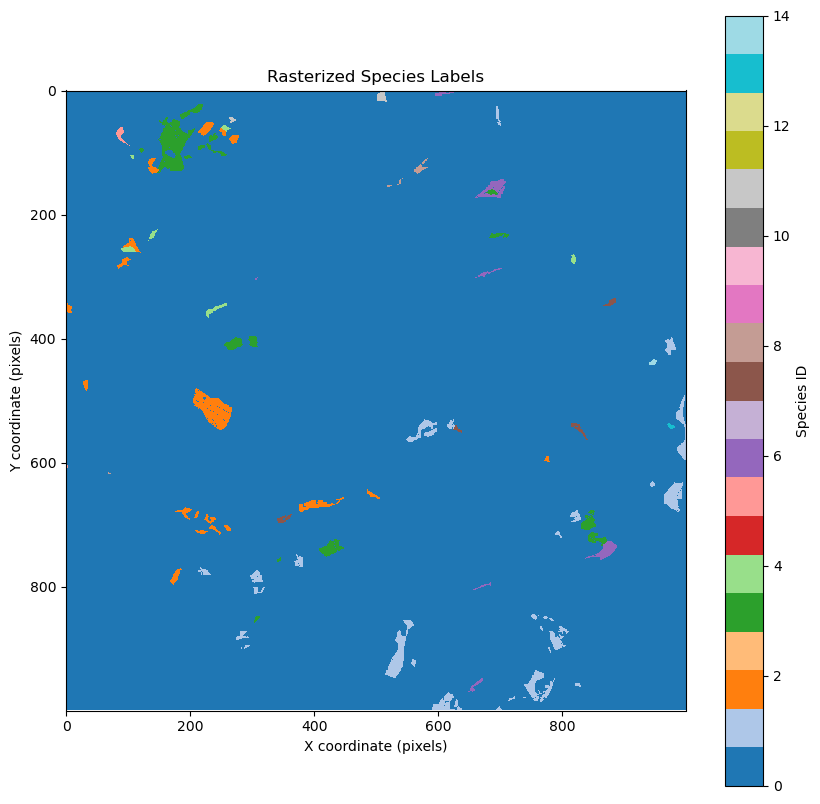

In [13]:
# Open the raster file
with rasterio.open('species_labels.tif') as src:
    # Read the raster data
    raster_data = src.read(1)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='tab20', interpolation='nearest')
plt.colorbar(label='Species ID')
plt.title('Rasterized Species Labels')
plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')
plt.show()